In [3]:
num_qubits = 9
rot = 3
# method = 'XY'
method = 'bl'

routing_method = 'basic'
optimization_level = 3
layout_method = 'trivial'

In [5]:
import os
from qiskit import qpy, QuantumCircuit

output_dir = os.getcwd()

aqc_truncated = QuantumCircuit(num_qubits)

qpy_path = os.path.join(output_dir, f"aqc_ansatz_{num_qubits}q_{rot}t_{method}steps_reverse.qpy")

with open(qpy_path, "wb") as f:
    qpy.dump(aqc_truncated, f)

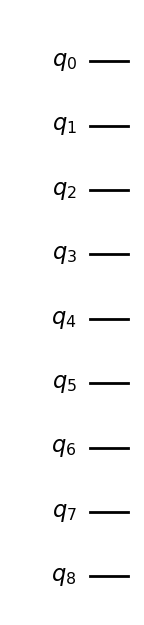

In [6]:
with open(qpy_path, "rb") as f:
   full_circuit = qpy.load(f)[0]

full_circuit.draw('mpl')

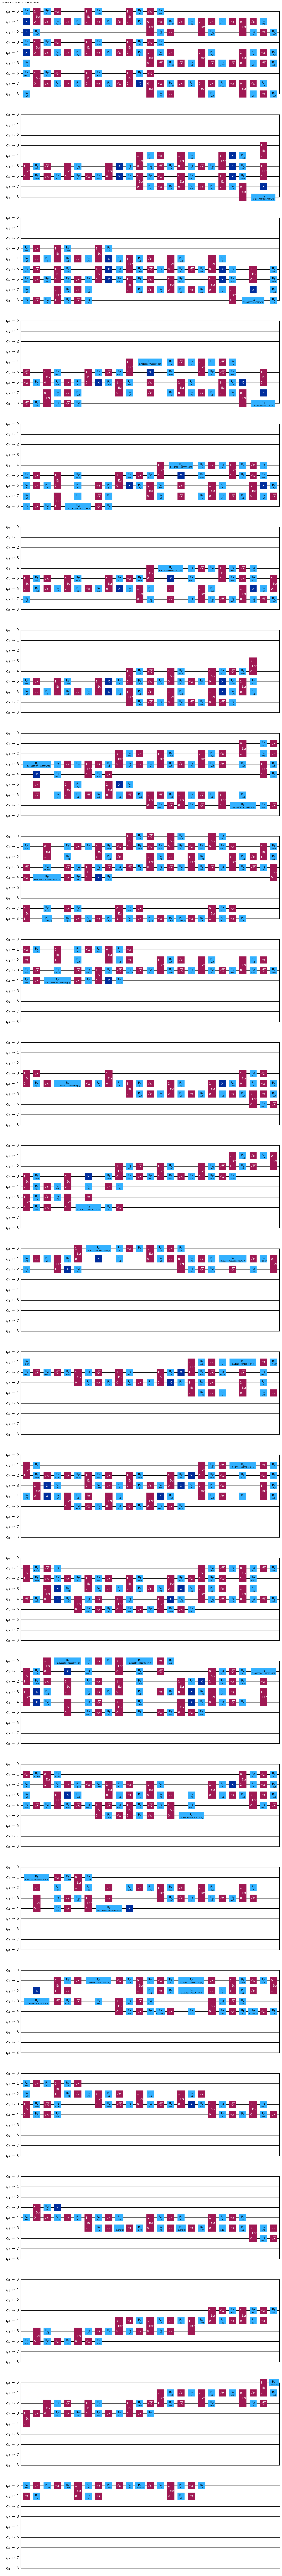

In [9]:
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

from qiskit import qpy

with open(f"full_circuit_{method}_opt_{num_qubits}_qubits.qpy", "rb") as f:
    full_circuit = qpy.load(f)[0]


backend = FakeSherbrooke()
 
pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, layout_method=layout_method, routing_method=routing_method, seed_transpiler=12345
)

qc_t1_exact = pass_manager.run(full_circuit)
qc_t1_exact.draw("mpl", idle_wires=False)

In [ ]:

op_counts = qc_t1_exact.count_ops()
total_gates = sum(op_counts.values())
two_qubit_gate_names = [name for name, count in op_counts.items() 
                        if any(len(op.qubits) == 2 for op in qc_t1_exact if op.operation.name == name)]
total_two_qubit_gates = sum(op_counts[name] for name in two_qubit_gate_names)
depth = qc_t1_exact.depth()
two_qubit_depth = qc_t1_exact.depth(
    filter_function=lambda instr: len(instr.qubits) == 2
)

In [ ]:
import pandas as pd
import csv
import os

file_path_depth = f"RESULTS/CNOTs/total_cnots_{rot}rots_XY_opt.csv"

data_depth = {
    "Experiment": ["Hardware XY-QAOA"],
    "Total number of gates": [total_gates],
    "Depth of the circuit": [depth],
    "CZs": [total_two_qubit_gates]
}

df_depth = pd.DataFrame(data_depth)

file_exists = os.path.isfile(file_path_depth) and os.path.getsize(file_path_depth) > 0

with open(file_path_depth, mode="a", newline="") as file:
    writer = csv.writer(file)

    # Write the header only if the file is new
    if not file_exists:
        writer.writerow(["Size", "Depth", "Two-Qubit Gates", "two_qubit Depth", "Total Gates"])
    
    # Append the new result
    writer.writerow([num_qubits, depth, total_two_qubit_gates, two_qubit_depth, total_gates])
